In [117]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [106]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, max_iter = 30000, hidden_layer_sizes = (100,), beta = 0.999, epsilon = 1e-8, tol = 1e-6):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.layers_dims = 1 + len(hidden_layer_sizes)
        self.epsilon = epsilon
        self.tol = tol
        self.beta = beta
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis = 1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis = 1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis = 0, keepdims = True)
    
    ########################################################################################################################
    
    def __initialize_parameters(self, X_len, hidden_layers, y_len):
        np.random.seed(1)
        W = list()
        b = list()
        h = list(hidden_layers)
        h.insert(0, X_len)
        h.append(y_len)
        hidden_layers = tuple(h)
        
        for i in range(1, self.layers_dims + 1):
            W.append(np.random.randn(hidden_layers[i], hidden_layers[i - 1]) / np.sqrt(
                hidden_layers[i - 1]))
            b.append(np.zeros((hidden_layers[i], 1)))

        self.parameters = {"W" : W, "b" : b}

        
        
    # Forward part
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]
        A = []
        Z = []
               
        for i in range(0, self.layers_dims - 1):
            if i == 0:
                Z.append(np.dot(W[i], X) + b[i])
            else:
                Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))####
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis = 1)
    
    def compute_cost(self, A, Y):
        J = - np.mean(Y.T * np.log(A.T + 1e-8))
        return J
    
    def to_classlabel(self, z):
        return z.argmax(axis = 1)
       
        
    # Backward part
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.layers_dims)
        dA = [None] * (self.layers_dims)
        dZ = [None] * (self.layers_dims)
        db = [None] * (self.layers_dims)
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.layers_dims - 1, 0, -1):
            dZ[i - 1] = np.multiply(dA[i], self.__sigmoid_derivative(Z[i - 1]))
            if i - 1 == 0:
                dW[i - 1] = 1. / m * np.dot(dZ[i - 1], X.T)
            else:
                dW[i-1] = 1. / m * np.dot(dZ[i - 1], A[i - 2].T)
            db[i - 1] = 1. / m * np.sum(dZ[i - 1], axis = 1, keepdims = True) 
            dA[i - 1] = np.dot(W[i-1].T, dZ[i - 1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.layers_dims):
            self.S_dW[i] = self.beta * self.S_dW[i] + (1 - self.beta) * np.power(dW[i], 2)
            self.S_db[i] = self.beta * self.S_db[i] + (1 - self.beta) * np.power(db[i], 2)
            W[i] = W[i] - self.learning_rate * dW[i] / (np.sqrt(self.S_dW[i]) + self.epsilon)
            b[i] = b[i] - self.learning_rate * db[i] / (np.sqrt(self.S_db[i]) + self.epsilon)
            
        self.parameters = {"W" : W, "b" : b}

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        costs = []
        cost_history = []
        m = X.shape[1]
        self.__initialize_parameters(X.shape[0], self.hidden_layer_sizes, Y.shape[0])

        self.S_dW = []
        self.S_db = []
        h = list(self.hidden_layer_sizes)
        h.insert(0, X.shape[0])
        h.append(Y.shape[0])
        hidden_layers = tuple(h)
        for i in range(1, self.layers_dims + 1):
            self.S_dW.append(np.zeros((hidden_layers[i], hidden_layers[i-1])))
            self.S_db.append(np.zeros((hidden_layers[i], 1)))
        
        for i in range(self.max_iter):
            self.n_iter = i
            A, cache = self.__forward_propagation(X)
            cost = self.compute_cost(A, Y)
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            cost_history.append(cost)
            
            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))
            if i % 100 == 0:
                costs.append(cost)
            if i > 1 and abs(cost - cost_history[-2]) < self.tol:
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X = self.__normalize(X, self.__mean, self.__std)
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  
    

In [107]:
df = pd.read_csv('train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
#data_columns = ["test1", "test2"]
#target_column = "passed"
#df = pd.read_csv("tests.csv")
#X, Y = df[data_columns].values, df[target_column]
y = df["label"]
X = df.drop('label', axis = 1)
###
print('Training set: X={}, y={}'.format(X.shape, y.shape))

Training set: X=(42000, 784), y=(42000,)


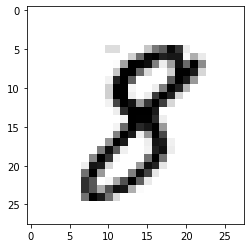

In [118]:
#plot_data(X, Y)

plt.imshow(X.iloc[20].values.reshape(28, 28), cmap=mpl.cm.binary)
plt.show()

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
print('Training set: X={}, y={}'.format(X_train.shape, y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, y_test.shape))

Training set: X=(33600, 784), y=(33600,)
Test set: X=(8400, 784), y=(8400,)


In [111]:
#normalize
X_train = X_train / 255
X_test = X_test / 255

y_train = to_categorical(y_train)

In [112]:
#cls = NeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 0.5, num_iter = 10000)
#cls = NeuralNet(layer_dims = [2,2,1] , learning_rate = 0.5, num_iter = 4000)
#cls = NeuralNet(layer_dims = [2,20,1], normalize = True, learning_rate = 1, num_iter = 14000)

cls = NeuralNet(normalize = False, learning_rate = 0.1, max_iter = 1000, hidden_layer_sizes = (50,), beta = 0.999, epsilon = 1e-8, tol = 1e-8)

0-th iteration: 0.23998284960196148
100-th iteration: 0.12564587559829332
200-th iteration: 0.10743448966033516
300-th iteration: 0.11787708675402227
400-th iteration: 0.07784809351739402
500-th iteration: 0.07346146406149598
600-th iteration: 0.05820121703697974
700-th iteration: 0.05445949905119655
800-th iteration: 0.04986046641441945
900-th iteration: 0.04903639322723672


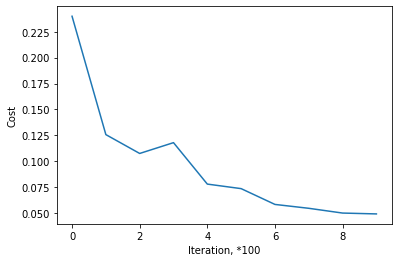

In [113]:
cls.fit(X_train, y_train)

In [119]:
print(cls.n_iter)

999


In [120]:
print(cls.parameters)

{'W': [array([[ 0.05801233, -0.02184844, -0.01886328, ..., -0.03952047,
        -0.01282943,  0.01804935],
       [ 0.04349789, -0.06931003, -0.02879208, ...,  0.00740107,
        -0.05121538,  0.02238951],
       [ 0.01070804, -0.06630862, -0.07682297, ..., -0.06979256,
         0.00665085, -0.00013678],
       ...,
       [-0.01888887, -0.01178202,  0.00488721, ..., -0.00135933,
         0.01519459,  0.0302878 ],
       [-0.00011539, -0.02882183, -0.0291148 , ..., -0.00321773,
         0.0026965 , -0.02912119],
       [-0.01333235, -0.05263958,  0.05322715, ...,  0.02176674,
        -0.0006411 ,  0.030889  ]]), array([[-2.68796373e+00, -2.94263799e+00,  1.12686142e+00,
         5.90965198e+00,  2.48809378e-03, -3.19520985e+00,
        -2.04296986e-01, -4.96124242e-01,  5.93562492e+00,
        -1.25843775e+00, -2.90390065e+00, -2.20870397e+00,
        -9.03690505e-02, -4.79955316e+00, -8.88450731e-01,
        -1.66477990e+00,  4.59317982e-02, -3.00141417e+00,
        -3.16938154e+00, 

In [121]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[8.48208525e-08, 9.43008327e-01, 1.98378844e-02, ...,
        3.03935245e-05, 3.40382011e-02, 1.15566457e-04],
       [9.03896806e-01, 4.27302589e-06, 1.13891417e-02, ...,
        4.17036078e-04, 2.85001947e-02, 3.51919021e-03],
       [5.80005509e-10, 9.86868349e-01, 9.64819962e-04, ...,
        1.11754365e-04, 1.53903293e-03, 1.30050791e-04],
       ...,
       [3.37131730e-08, 1.76352052e-06, 1.75365426e-03, ...,
        9.89307990e-01, 6.03350576e-06, 3.61470658e-03],
       [7.46135861e-03, 6.90310153e-04, 2.65611796e-02, ...,
        9.44762670e-05, 3.72155916e-03, 9.01289089e-04],
       [1.73604248e-02, 9.20059113e-07, 1.39605062e-02, ...,
        2.79299842e-01, 1.68006921e-03, 3.13860391e-01]])

In [135]:
Y_hat = cls.predict(X)
Y_hat

array([1, 0, 1, ..., 7, 6, 4], dtype=int64)

In [134]:
Y_hat[20]

8

In [132]:
accuracy_score(y, Y_hat)

0.8554761904761905

In [114]:
#plot_data(X, Y)
#plot_surface(cls, X[:, 0], X[:, 1])

In [125]:
Y_hat = cls.predict(X_test)
Y_hat

array([8, 1, 9, ..., 3, 0, 4], dtype=int64)

In [126]:
accuracy_score(y_test, Y_hat)

0.8505952380952381

In [141]:
#from sklearn.neural_network import MLPClassifier
#clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [142]:
#clf.fit(X, y)

In [143]:
#plot_data(X, Y)
#plot_surface(clf, X[:, 0], X[:, 1])

In [144]:
#accuracy_score(Y, clf.predict(X))